In [2]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal

from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace

from scipy.linalg import sqrtm,inv

In [3]:
# def make_hann_2D(n):
#     w = scipy.signal.hann(n)
#     wx,wy = np.meshgrid(w,w)
#     w2 = wx*wy
#     return w2, sqrt(np.mean(w2**2))

def make_bins(lmin,lmax,nbins,uselogbins):
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else: 
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    return lbincenters,lbinedges

def img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True):
    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins)

    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
    lx,ly = meshgrid(lvals,lvals)
    lmag  = sqrt(lx**2+ly**2)
    print(np.max(lmag))

    wind,windrms = np.ones((n,n)),1
    if usehann: wind,windrms = make_hann_2D(n)
    img_ft = fft.fft2((img-img.mean())*wind)/windrms
    
    pspec_binned = np.zeros(nbins)

    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini])&(lmag<lbinedges[bini+1])
        bin_counts[bini] = np.sum(inbin)

        pspec_binned[bini] = np.mean(np.abs(img_ft[inbin])**2)

    pspec_norm = (dtheta_rad**2)/(n**2)
    return lbincenters,pspec_binned*pspec_norm,bin_counts

In [4]:
# generate an image from a non-flat power spectrum
n = 50
dtheta_amin = 3.
dtheta_rad = dtheta_amin/60*pi/180

lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
lxgrid,lygrid = meshgrid(lvals,lvals)
lmaggrid = sqrt(lxgrid**2+lygrid**2)

img_ft = (random.randn(n,n)+1j*np.random.randn(n,n))*1./(1+lmaggrid)
img = np.real(fft.ifft2(img_ft)) # taking the real part enforces conjugate symmetry in fourier space

mask = random.randn(n,n)>-.8

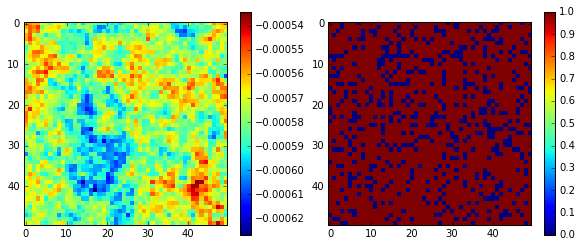

In [5]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(img,interpolation='nearest')
plt.colorbar()

plt.subplot(122)
plt.imshow(mask,interpolation='nearest')
plt.colorbar()

In [6]:
# computer FFT-based power spectra

# lmin,lmax = 300,5000
lmin,lmax = 150,5000
uselogbins = True
nbins = 20
img_meas = img*mask

lbins,pspec,bin_counts = img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=uselogbins,usehann=False)
lbins,pspec_m,bin_counts = img2PS(img_meas,dtheta_rad,nbins,lmin,lmax,uselogbins=uselogbins,usehann=False)

5091.16882454
5091.16882454


/Users/abrahamn/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/abrahamn/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
# begin setup for optimal PS estimator

lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins=uselogbins)
    
lvals = fft.fftfreq(n)*2*pi/dtheta_rad # ell values
lxgrid,lygrid = meshgrid(lvals,lvals)
lmaggrid = sqrt(lxgrid**2+lygrid**2)

thvals = (arange(n)-n/2)*dtheta_rad # theta values
thxgrid,thygrid = meshgrid(thvals,thvals)

In [12]:
xir = matrix(img_meas.flatten()).T

In [14]:
# put in a guess of the data covariance

Cguess_ft = 2*matrix(np.diag(1./(1+lmaggrid.flatten())**2))
# Cguess_ft = matrix(np.diag(np.ones(n*n)))

In [15]:
# generate the fourier transform matrix

lxvals,thxvals = meshgrid(lxgrid.flatten(),thxgrid.flatten()) # ell_x and theta_x
lyvals,thyvals = meshgrid(lygrid.flatten(),thygrid.flatten()) # ell_y and theta_y
F = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))/n**2

In [26]:
# make C^{-1}, taking into account the data covariance and pixel masking 

Csignal = F*Cguess_ft*conj(F).T
Cmask = 1.e6*np.matrix(np.diag(img_meas.flatten()==0)) # IS THIS A REASONABLE NUMBER ??
Cinv = inv(Csignal + Cmask)

# 18 sec

In [40]:
def gen_Ccommabini(bini):
    inbin = (lmaggrid>=lbinedges[bini])*(lmaggrid<lbinedges[bini+1])
    ivals_inbin,jvals_inbin = where(inbin)

    lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
    lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
    Ccommabini_0 = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
    Ccommabini = Ccommabini_0*conj(Ccommabini_0.T)

    return Ccommabini
Ccomma_mats = [gen_Ccommabini(i) for i in range(nbins)]

In [12]:
# calculate q_alpha

q = np.matrix(np.zeros((nbins,1)))
Ccomma_times_Cinv_mats = []
for bini in range(nbins):
    print('bini = %d'%bini)
    Ccommabini_times_Cinv = gen_Ccommabini(bini)*Cinv
    Ccomma_times_Cinv_mats.append(Ccommabini_times_Cinv)
    q[bini] = .5*real(xir.T*Cinv*Ccommabini_times_Cinv*xir).item()

# calculate Fisher matrix

Fish = np.matrix(np.zeros((nbins,nbins)))
for i in range(nbins):
    print(i)
    for j in range(i,nbins):
        Fish[i,j] = np.real(.5*trace(Ccomma_times_Cinv_mats[i]*Ccomma_times_Cinv_mats[j]))
        Fish[j,i] = Fish[i,j]

bini = 0
bini = 1
bini = 2
bini = 3
bini = 4
bini = 5
bini = 6
bini = 7
bini = 8
bini = 9
0
1
2
3
4
5
6
7
8
9


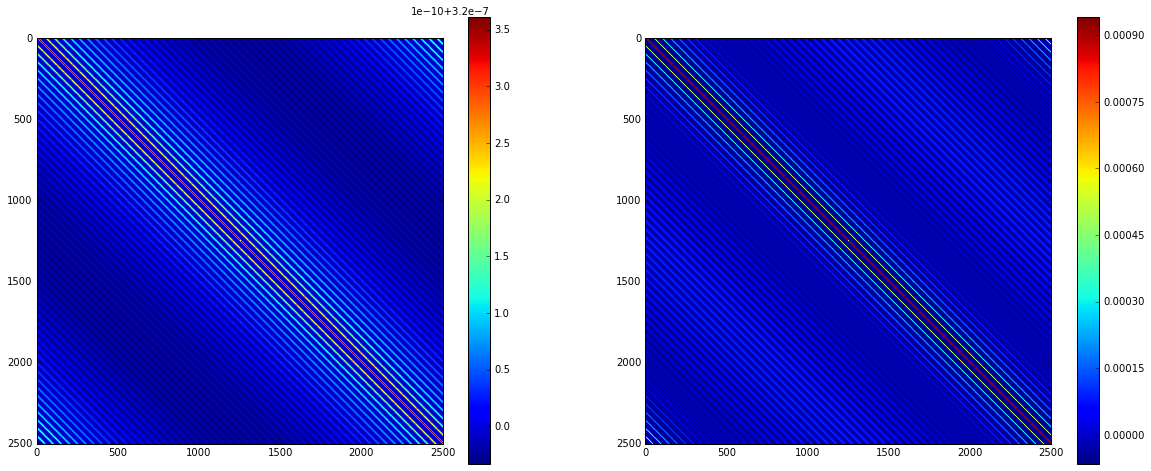

In [41]:
# WHY DON'T THESE AGREE????? SEEMS TO DEPEND ON THE BINNING...

plt.figure(figsize=(20,8))

# C = F*diag(variance in fourier space)*F^\dagger

plt.subplot(121)
plt.imshow(np.real(Csignal),interpolation='nearest')
plt.colorbar()


# C = \sum_\alpha p_\alpha C_{,\alpha}

Csignal2 = np.sum([Ccomma_mats[i]/lbincenters[i]**2 for i in range(nbins)],axis=0)
plt.subplot(122)
plt.imshow(np.real(Csignal2),interpolation='nearest')
plt.colorbar()

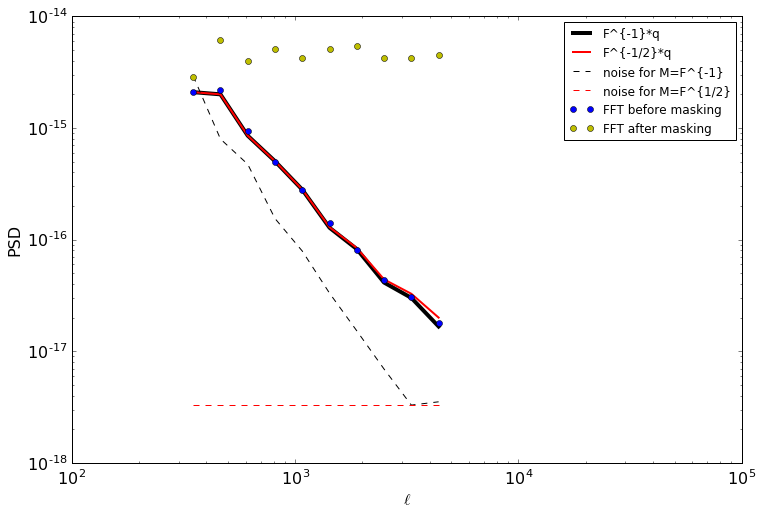

In [14]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(12,8))

def vec2arr(v):
    return np.array(v).flatten()

norm = (dtheta_rad**2)/(n**2)*n**4

plt.loglog(lbincenters,vec2arr(inv(Fish)*q)*norm,'k-',label='F^{-1}*q',linewidth=4)
plt.loglog(lbincenters,vec2arr(sqrtm(inv(Fish))*q)*norm/vec2arr(np.max(sqrt(Fish),axis=0)),'r-',label='F^{-1/2}*q',linewidth=2)

plt.loglog(lbincenters,np.sqrt(1./np.diag(Fish))*norm,'k--',label='noise for M=F^{-1}')
plt.loglog(lbincenters,np.ones(nbins)*norm/vec2arr(np.max(sqrt(Fish))),'r--',label='noise for M=F^{1/2}')

plt.loglog(lbins,pspec,'bo',label='FFT before masking')
plt.loglog(lbins,pspec_m,'yo',label='FFT after masking') 

plt.legend(fontsize=12)
plt.xlim([100,1.e5])
plt.xlabel('$\ell$')
plt.ylabel('PSD')

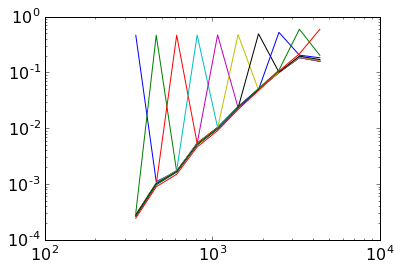

In [15]:
# window functions, W = M*F

# if M = 1./F, then W = identity matrix

# if M = F^{-.5}, then W = F^{.5}, and we must normalize the window functs so they sum to 1 along either rows or cols, not sure which?


# window functions for M = F^{-1/2}
for i in range(nbins):
    w = vec2arr(sqrt(Fish[:,i]))
    plt.loglog(lbincenters,w/np.sum(w))

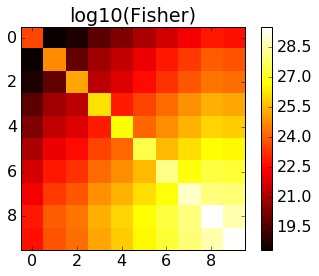

In [16]:
plt.imshow(np.log10(Fish),interpolation='nearest',cmap='hot')
plt.colorbar()
plt.title('log10(Fisher)')